In [159]:
###Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Image
from IPython.core.display import HTML
import datetime
import math
import scipy.optimize as optimize
import statistics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
import scipy
import warnings
from scipy.stats import norm
from sklearn import datasets, linear_model, cross_validation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold 
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
from IPython.display import Image
from IPython.core.display import HTML 
import xgboost

In [3]:
### data loading 
df = pd.read_csv('./data/loan.csv', low_memory=False)

In [4]:
### data loading & cleaning
df = df.drop_duplicates(subset='id').reset_index(drop=True)
df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['id', 'funded_amnt','int_rate','installment','grade'])
df = df[np.isfinite(df['annual_inc']) & np.isfinite(df['int_rate']) &  np.isfinite(df['funded_amnt'])].copy()

In [5]:
###changing data type to appropriate date type 
df['last_pymnt_d']=pd.to_datetime(df.last_pymnt_d)
df['issue_d']=pd.to_datetime(df.issue_d)

In [6]:
###fill missing last_payments(no payments) with issue date, may want a separete column for this treatment
###This is for calculation of IRRs later
df['last_pymnt_d'].fillna(df.issue_d,inplace=True)

In [7]:
###Some pre-processing for ease of calculations
df['issue_yr'] = df.issue_d.dt.year
df['issue_mo']= df.issue_d.dt.month
df['last_pymnt_yr'] = df.last_pymnt_d.dt.year
df['last_pymnt_mo']= df.last_pymnt_d.dt.month
df['mo_diff'] = pd.to_numeric((df['last_pymnt_yr'] - 
                          df['issue_yr'])*12 + df['last_pymnt_mo'] -df['issue_mo'])

In [8]:
###Flag for completed loans
searchfor = ['Fully Paid', 'Charged Off', 'Default']
defaults = ['Charged Off', 'Default']
df['loan_completion_flag']=  np.where(df['loan_status'].str.contains('|'.join(searchfor)) ,1, np.nan)
###Flag for fully paid loans
df['fully_paid'] = np.where(df['loan_status'].str.contains('Fully Paid') ,1, 
                                  np.where(df['loan_status'].str.contains('|'.join(defaults)) ,0,np.nan))


In [9]:
###Average payment = Total payment - recoveries - last payment amount over the life -1 month of the investment
df['avg_pymnt'] = (df['total_pymnt']-df['recoveries']-df['last_pymnt_amnt'])/(np.maximum((df['mo_diff']-1),0))
###Treating infinites that appear when there is no payment or only 1 payment 
df['avg_pymnt'] = (df['avg_pymnt']).replace(np.Inf,0)
df['avg_pymnt'] = (df['avg_pymnt']).replace(-np.Inf,0)

In [10]:
###IRR calculations
###Input: a row of a dataframe with lending data 
def irr_calc(x):  
    ##varible initialization
    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = np.max(int(x['mo_diff'])-1,0)
    recovery = x['recoveries'] -x['collection_recovery_fee']
    recovery_duration = np.maximum(36 - num_payments + 1 + 12,12)
    avg_recovery = recovery/recovery_duration
    last_payment_amount = x['last_pymnt_amnt']
    ###IRR calculation, input: series of cash flows, total payment - recoveries
    ###evenly divided and spread across the life of the loan and finally recovery and chargeoff fees
    return ((np.irr([initial_invest]+[avg_payment]*num_payments + [last_payment_amount] +
                    [avg_recovery]*recovery_duration)+1)**12-1)

In [11]:
###Calculating at a row level, individual security IRRs. Method will be faulty for loans that didn't mature.
###Warning: the calculation takes a fair amount of time ~few minutes
df['irr']=df.apply(irr_calc, axis=1)

In [12]:
##NaNs returned from IRRs with 0 payments should be -100% return 
df['irr']=df['irr'].replace(np.NaN,-1)

In [13]:
####Filter down to completed loans and has at least 36 months of possible history
df_filtered = df[df['loan_status'].str.contains('|'.join(searchfor))].query("term == ' 36 months' and issue_yr <=2012").copy()

In [37]:
##making grade flags
grade_flags = pd.get_dummies(df_filtered.grade) 
home_flag = pd.get_dummies(df_filtered.home_ownership) 
purpose_flag = pd.get_dummies(df_filtered.purpose)
df_filtered=pd.concat([df_filtered,grade_flags,home_flag,purpose_flag], axis=1)


In [44]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

# Model Testing

In [190]:
columns= ["int_rate","annual_inc","funded_amnt","A","B","C","D","E","F","G","MORTGAGE","NONE",
          "OTHER","OWN","RENT","car","credit_card","debt_consolidation","educational","home_improvement","house",
         "major_purchase","medical","moving","other","renewable_energy","small_business","vacation","wedding"]

Using nested cross validation.

In the last [post](http://jameslee.posthaven.com/peer-to-peer-lending-markets-part-2-using-linear-regression-and-gradient-boosting-regression-to-outperform-the-market), gbm regression model and linear regression were pitted against random loan selection method to see if we can outperform a well diversified market portfolio, and we saw that our models dramatically outperformed the market portfolio. So with that exploratory work out of the way, I will aim to build an excellent model that can potentially be used in practice. First order of the business is feature selection. We will use feature importance and Instead of using K-Fold cross validation like last time, I will split the data into 70/30 training and test set and use in-sample accuracies to feature select and tune the model. Then we will test its performance in our test set.

Ideally, we tune the parameters and feature selection at the same time, but this is not feasible for my computation resources. So we will first feed all the features, run tuning once, then figure out the appropriate features using those parameters as a baseline then run the parameter tuning once again to arrive at a final model.

In [166]:
df_train, df_test = cross_validation.train_test_split(df_filtered,test_size=.3)

In [192]:
len(columns)

29

In [157]:
parameters = {
    "loss":["ls"],
    "learning_rate": [0.005,0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[2,4,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[50, 100, 200, 500, 1000]
    }

In [164]:
clf = GridSearchCV(ensemble.GradientBoostingRegressor(), parameters, cv=10, n_jobs=-1)

In [165]:
cross_val_score(clf, df_train[columns], df_train['irr'])

KeyboardInterrupt: 

In [167]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(df_train[columns], df_train['irr'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [168]:
importance = clf.feature_importances_

In [180]:
np.ceil(len(columns)/4)

8.0

In [189]:
df_train.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
       'other', 'renewable_energy', 'small_business', 'vacation', 'wedding'],
      dtype='object', length=121)

In [183]:
importance.argsort()[-(len(importance)-30):][::-1]

array([ 1,  0,  2, 38, 28, 14, 13, 29, 10,  9, 36], dtype=int64)

In [120]:
kf = KFold(n_splits=4) # Define the split - into 4

for i in range(np.ceil(len(columns)/6)):
    sorted_features = importance.argsort()[-(len(importance)-i*6):][::-1]
    for index, (train, test) in enumerate(kf.split(df_train)):
        x_train = df_train.iloc[train][columns].iloc[:,sorted_features]
        y_train = df_filtered.iloc[train]['irr']
        y_test = df_filtered.iloc[test]['irr']
        x_test = df_filtered.iloc[test][columns]

        params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls'}

        clf = ensemble.GradientBoostingRegressor(**params)
        clf.fit(x_train_less, y_train)
        gbm_predictions = clf.predict(x_train_less)
        df_temp = pd.DataFrame({'irr':y_train, 'gbm_predictions':gbm_predictions})
        gbm_returns = np.mean(df_temp.nlargest(1000, 'gbm_predictions')['irr'])
        all_trials.append({
            'n_features': i,
            'in_sample_mse': calc_train_error(x_train_less,y_train,clf),
            'in_sample_returns': gbm_returns
        })

KeyboardInterrupt: 

In [ ]:
output=pd.DataFrame.from_records(all_trials)

Below are the average accuracies(mean squared error) and returns over our 10 validation sets. It seems that linear regression won out on both metrics. 

In [20]:
print('gbm_accuracy:', np.mean(output['gbm_mse']),', linear regression accuracy:' ,np.mean(output['lm_mse']),', xgb accuracy:' ,np.mean(output['xgb_mse']))  

gbm_accuracy: 0.0458416092504146 , linear regression accuracy: 0.0460898257975774 , xgb accuracy: 0.04623096395676446


In [21]:
print('gbm_returns:', np.mean(output['gbm_returns']),', linear regression returns:' ,np.mean(output['lm_returns']),', xgb returns:' ,np.mean(output['xgb_returns']))

gbm_returns: 0.10226936194421943 , linear regression returns: 0.11078926336649356 , xgb returns: 0.10312736470708257


Since we collected 10 trials across 10 validation sets, we can plot these accuracy and return measures. 

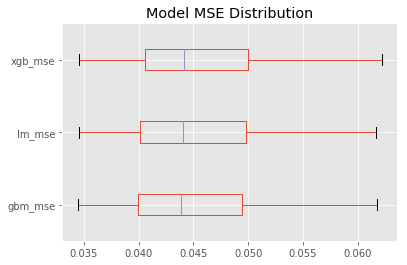

In [22]:
output[['gbm_mse', 'lm_mse','xgb_mse']].boxplot(vert=False)
plt.title('Model MSE Distribution')
plt.show()

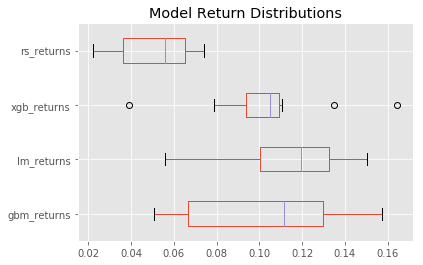

In [23]:
output[['gbm_returns', 'lm_returns', 'xgb_returns','rs_returns']].boxplot(vert=False)
plt.title('Model Return Distributions')
plt.show()

Both of our models far outperformed the random sampling method, almost doubling the returns. This is a strong indication that our model can garner insights from the features to select loans that are less likely to default, and yield higher returns. Should you invest into a peer-to-peer lending market, I would advise using signals to try to get a better return rather than using one of the platform's proprietary automated investment strategy. One thing we must be cognizant of is that even though we applied cross validation to minimize bias, there may be some look ahead bias in our dataset in a sense that we are using complete information of the loans that would otherwise not be available at the time of investment. So further testing would be required by employing these models on new loans, and then observing its returns over its life time. However, that would be an unrealistic effort.

In terms of the models, Linear regression not only yields consistently better accuracies but also yields higher returns than the GBM method. However, we chose our features using nested model testing on linear regression models and then used the same features for the GBM method. In the next post, we will investigate hyperparameter tuning and feature selection to try to build a GBM model that can outperform the linear regression model.
